In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
  def __init__(self,data,_children=(),_op='',label=""): #children for storing the values and op for operations
    self.data=data
    self.grad=0
    self._backward=lambda:None
    self._prev=set(_children)
    self._op=_op
    self.label=label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __rmul__(self,other): #other* self
    return self * other

  def __radd__(self,other):
    return self + other

  def __mul__(self,other):
    other = other if isinstance(other, Value) else Value(other)
    out=Value(self.data * other.data,(self,other),'*')

    def _backward():
      self.grad+= out.grad * other.data
      other.grad+= out.grad * self.data

    out._backward= _backward
    return out

  def __pow__(self,other):
    assert isinstance(other,(int,float)), " only supporting int and float for now"
    out = Value(self.data**other,(self,),f'**{other}')

    def _backward():
      self.grad += other*((self.data)**(other-1)) * out.grad

    out._backward=_backward
    return out

  def __truediv__(self,other): #self/other
    return self * other**-1

  def tanh(self):
    x= self.data
    t= (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t,(self,),'tanh')
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward= _backward

    return out

  def __neg__(self): # -self
    return self * -1

  def __sub__(self,other): #self-other
    return self + (-other)

  def __add__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out=Value(self.data+other.data,(self,other),'+')

    def _backward():
      self.grad+= 1.0 * out.grad
      other.grad+= 1.0 * out.grad

    out._backward= _backward
    return out

  def exp(self):
    x= self.data
    out = Value(math.exp(x),(self,),'exp')

    def _backward():
      self.grad+= out.data * out.grad
    out._backward= _backward
    return out

  def backward(self):
    topo=[]
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad=1.0
    for node in reversed(topo):
      node._backward()

In [10]:
from graphviz import Digraph

def trace(root):
  #builds a set of all nodes and edges in a graph
  nodes,edges=set(),set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
    for child in v._prev:
      edges.add((child,v))
      build(child)
  build(root)
  return nodes,edges

def draw_dot(root):
  dot=Digraph(format='svg',graph_attr={'rankdir':'LR'}) #LR= left to right

  nodes,edges = trace(root)
  for n in nodes:
    uid=str(id(n))
    #for any value in the graph,create a rectangular ('record') node for it
    dot.node(name=uid,label="{ %s | data %.4f | grad %.4f}" % (n.label,n.data, n.grad),shape='record')
    if n._op:
      #if this value is a result of some operation,create an op node for it
      dot.node(name=uid+n._op,label=n._op)
      # and connect this node to it
      dot.edge(uid+n._op,uid)
  for n1,n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)),str(id(n2))+n2._op)
  return dot

In [8]:
#inputs x1,x2
x1= Value(2.0, label='x1')
x2= Value(0.0, label='x2')
#weight w1,w2
w1= Value(-3.0, label='w1')
w2= Value(1.0, label='w2')
#bias of the neuron
b=Value(6.8813735870195432,label='b')
# x1w1 * x2w2 + b
x1w1=x1*w1; x1w1.label='x1*w1'
x2w2=x2*w2; x2w2.label='x2*w2'
x1w1x2w2= x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n= x1w1x2w2+b; n.label='n'

o=n.tanh(); o.label='o'
o.backward()

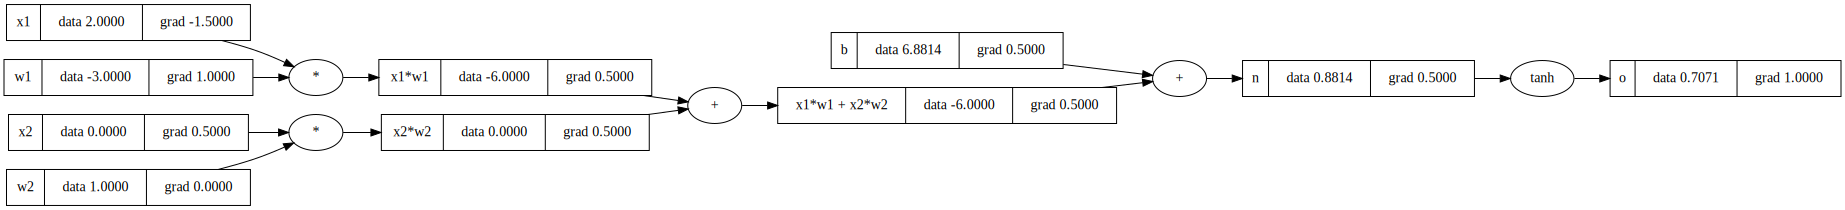

In [12]:
draw_dot(o)

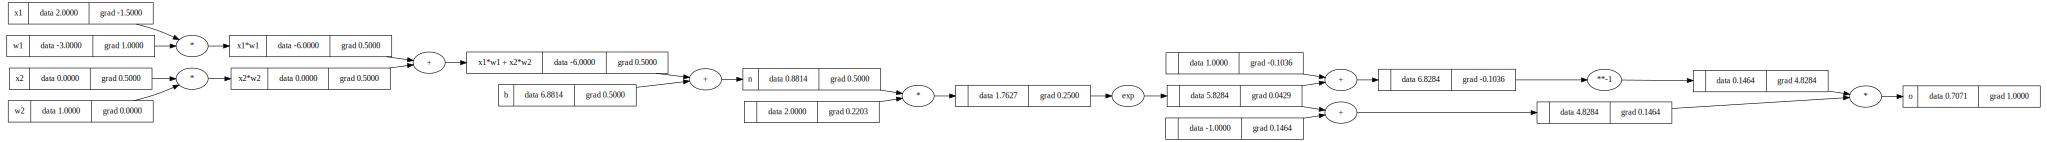

In [13]:
#inputs x1,x2
x1= Value(2.0, label='x1')
x2= Value(0.0, label='x2')
#weight w1,w2
w1= Value(-3.0, label='w1')
w2= Value(1.0, label='w2')
#bias of the neuron
b=Value(6.8813735870195432,label='b')
# x1w1 * x2w2 + b
x1w1=x1*w1; x1w1.label='x1*w1'
x2w2=x2*w2; x2w2.label='x2*w2'
x1w1x2w2= x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n= x1w1x2w2+b; n.label='n'
#----------
e= (2*n).exp()
o= (e - 1) / (e + 1)
#---------
o.label='o'
o.backward()
draw_dot(o)

Now the same but with Torch API

In [28]:
import torch as torch

In [29]:
x1 = torch.Tensor([2.0]).double()                              ; x1.requires_grad= True
x2 = torch.Tensor([0.0]).double()                              ; x2.requires_grad= True
w1 = torch.Tensor([-3.0]).double()                             ; w1.requires_grad= True
w2 = torch.Tensor([1.0]).double()                              ; w2.requires_grad= True
b = torch.Tensor([6.8813735870195432]).double()                ; b.requires_grad= True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item())
o.backward()

print('--------------')
print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())

0.7071066904050358
--------------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [31]:
torch.Tensor([1]).float().dtype

torch.float32

Creating a Neuron with nanograd

In [17]:
import random

In [18]:
class Neuron:
  def __init__(self,nin):  #nin number of inputs in the neuron
    self.w= [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b= Value(random.uniform(-1,1))

  def __call__(self, x):
      # Compute the dot product of weights and inputs, then add bias
      act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
      out = act.tanh()
      return out
  def parameters(self):
      return self.w + [self.b]

class Layer:
  def __init__(self,nin,nout):
    self.neurons=[Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs= [n(x) for n in self.neurons ]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
    # params= []
    # for neuron in self.neurons:
    #   ps = neuron.parameters()
    #   params.extend(ps)
    # return params

class MLP:
  def __init__(self,nin,nouts):
    sz=[nin]+nouts
    self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
  def __call__(self,x):
    for layer in self.layers:
      x=layer(x)
    return x
  def parameters(self):
    return [p for neuron in self.layers for p in neuron.parameters()]


In [19]:
x=[2.0,3.0,-1.0]
n=MLP(3,[4,4,1])
n(x)

Value(data=-0.06100999166839062)

In [20]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0],
 ]
ys = [1.0,-1.0,-1.0,1.0] #desired targets

In [26]:
for k in range(20):
  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout-ygt)**2 for ygt, yout in zip(ys,ypred))

  #backward pass
  for p in n.parameters():
    p.grad=0.0
  loss.backward()

  #update
  for p in n.parameters():
    p.data += -0.05 * p.grad
  print(k,loss.data)

0 0.0069851292034944935
1 0.006851831638064703
2 0.006723341576397475
3 0.006599408461387807
4 0.006479798650651821
5 0.006364294023762722
6 0.006252690724123815
7 0.006144798020596378
8 0.006040437275846192
9 0.005939441009963365
10 0.005841652049287936
11 0.005746922751567574
12 0.005655114299610508
13 0.005566096056501158
14 0.0054797449762327075
15 0.005395945064301147
16 0.005314586883407657
17 0.005235567099946737
18 0.0051587880674224176
19 0.00508415744334544


In [27]:
ypred

[Value(data=0.9697600649491519),
 Value(data=-0.9581793232968895),
 Value(data=-0.9641259414378853),
 Value(data=0.9663282508051363)]